# Simple Audio Fingerprinting and Matching Demo

This notebook demonstrates a simplified audio fingerprinting and matching process.

## Prerequisites

- **Audio Files**: Place one full song (WAV) and a 10-second clip (WAV) in a `./audio` folder. Example: `song1.wav`, `clip1.wav`.
- **Dependencies**: Install required Python packages.
- **Environment**: Run in a Jupyter notebook with access to ffmpeg for audio processing (if converting MP3 to WAV).

## Setup

Install dependencies and create an audio folder:

In [ ]:
!pip install librosa numba xxhash matplotlib numpy scipy
!mkdir -p ./audio
# You may need ffmpeg to convert audio formats or extract clips.*
# Example:
# Convert MP3 to WAV: !ffmpeg -i ./audio/your_song.mp3 ./audio/song1.wav
# Extract 10-second clip: !ffmpeg -i ./audio/song1.wav -ss 60 -t 10 -c copy ./audio/clip1.wav

The syntax of the command is incorrect.


## Define simple fingerprinting and matching functions and their dependencies

Define simplified functions for fingerprinting and matching, including necessary imports and helper functions.

In [2]:
from typing import List, Tuple
from numba import jit
import xxhash
from operator import itemgetter
from collections import Counter
import numpy as np
import librosa
import matplotlib.pyplot as plt
import logging
import os

# Configuration (simplified for the demo)
CONFIG = {
    'DEFAULT_FS': 44100,
    'DEFAULT_WINDOW_SIZE': 2048,
    'DEFAULT_OVERLAP_RATIO': 0.5,
    'DEFAULT_FAN_VALUE': 15,
    'DEFAULT_AMP_MIN': -20,
    'PEAK_NEIGHBORHOOD_SIZE': 10,
    'MIN_HASH_TIME_DELTA': 0,
    'MAX_HASH_TIME_DELTA': 500,
    'FINGERPRINT_REDUCTION': 20,
    'PEAK_SORT': True
}

# Setup basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@jit(nopython=True)
def get_2D_peaks_numba(arr2D: np.ndarray, amp_min: float, peak_neighborhood_size: int) -> List[Tuple[int, int]]:
    """Optimized peak detection with numba."""
    peaks = []
    rows, cols = arr2D.shape
    neighborhood_size = peak_neighborhood_size // 2
    for i in range(neighborhood_size, rows - neighborhood_size):
        for j in range(neighborhood_size, cols - neighborhood_size):
            if arr2D[i, j] > amp_min:
                is_max = True
                for di in range(-neighborhood_size, neighborhood_size + 1):
                    for dj in range(-neighborhood_size, neighborhood_size + 1):
                        if di == 0 and dj == 0:
                            continue
                        if arr2D[i + di, j + dj] > arr2D[i, j]:
                            is_max = False
                            break
                    if not is_max:
                        break
                if is_max:
                    peaks.append((i, j))
    return peaks

def get_2D_peaks(arr2D: np.ndarray, plot: bool = False, amp_min: float = CONFIG['DEFAULT_AMP_MIN'],
                 peak_neighborhood_size: int = CONFIG['PEAK_NEIGHBORHOOD_SIZE']) -> List[Tuple[int, int]]:
    """Extract peaks from spectrogram."""
    try:
        peaks = get_2D_peaks_numba(arr2D, amp_min, peak_neighborhood_size)
        # logger.info(f"Detected {len(peaks)} peaks with amp_min={amp_min}") # Removed for simplicity in this demo
        if plot:
            plt.figure(figsize=(10, 6))
            plt.imshow(arr2D, origin='lower', aspect='auto', cmap='viridis')
            if peaks:
                freqs, times = zip(*peaks)
                plt.scatter(times, freqs, c='r', s=10, label='Peaks')
            plt.colorbar(label='Amplitude (dB)')
            plt.xlabel('Time (frames)')
            plt.ylabel('Frequency (bins)')
            plt.title(f'Spectrogram with Detected Peaks (amp_min={amp_min})')
            plt.legend()
            plt.show()
        return peaks
    except Exception as e:
        logger.error(f"Peak detection failed: {e}")
        return []

def generate_hashes(peaks: List[Tuple[int, int]], fan_value: int = CONFIG['DEFAULT_FAN_VALUE'],
                    min_hash_time_delta: int = CONFIG['MIN_HASH_TIME_DELTA'],
                    max_hash_time_delta: int = CONFIG['MAX_HASH_TIME_DELTA'],
                    fingerprint_reduction: int = CONFIG['FINGERPRINT_REDUCTION'],
                    peak_sort: bool = CONFIG['PEAK_SORT']) -> List[Tuple[str, int]]:
    """Generate hashes from peaks."""
    try:
        if peak_sort:
            peaks.sort(key=itemgetter(1))
        hashes = []
        valid_pairs = 0
        for i in range(len(peaks)):
            for j in range(1, fan_value):
                if (i + j) < len(peaks):
                    freq1 = peaks[i][0]
                    freq2 = peaks[i + j][0]
                    t1 = peaks[i][1]
                    t2 = peaks[i + j][1]
                    t_delta = t2 - t1
                    if min_hash_time_delta <= t_delta <= max_hash_time_delta:
                        valid_pairs += 1
                        h = xxhash.xxh64(f"{freq1}|{freq2}|{t_delta}".encode('utf-8'))
                        hash_str = h.hexdigest()[:fingerprint_reduction]
                        hashes.append((hash_str, t1))
        # logger.info(f"Generated {valid_pairs} valid peak pairs for hashing") # Removed for simplicity in this demo
        return hashes
    except Exception as e:
        logger.error(f"Hash generation failed: {e}")
        return []


def simple_fingerprint(channel_samples, Fs, plot=False): # Added plot parameter
    """Generate fingerprints from audio samples using fixed parameters."""
    try:
        samples = channel_samples.astype(np.float32) / 32768.0
        wsize = CONFIG['DEFAULT_WINDOW_SIZE']
        wratio = CONFIG['DEFAULT_OVERLAP_RATIO']
        hop_length = int(wsize * (1 - wratio))
        S = librosa.stft(samples, n_fft=wsize, hop_length=hop_length, window='hann')
        arr2D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

        amp_min = CONFIG['DEFAULT_AMP_MIN']
        peak_neighborhood_size = CONFIG['PEAK_NEIGHBORHOOD_SIZE']
        peaks = get_2D_peaks(arr2D, plot=plot, amp_min=amp_min, peak_neighborhood_size=peak_neighborhood_size) # Pass plot parameter

        fan_value = CONFIG['DEFAULT_FAN_VALUE']
        min_hash_time_delta = CONFIG['MIN_HASH_TIME_DELTA']
        max_hash_time_delta = CONFIG['MAX_HASH_TIME_DELTA']
        fingerprint_reduction = CONFIG['FINGERPRINT_REDUCTION']
        peak_sort = CONFIG['PEAK_SORT']

        hashes = generate_hashes(peaks, fan_value=fan_value,
                                min_hash_time_delta=min_hash_time_delta,
                                max_hash_time_delta=max_hash_time_delta,
                                fingerprint_reduction=fingerprint_reduction,
                                peak_sort=peak_sort)
        return hashes
    except Exception as e:
        logger.error(f"Simple fingerprinting failed: {e}")
        return []

def simple_match(clip_samples, clip_sr, song_fingerprints, plot=False): # Added clip_samples, clip_sr, and plot parameters
    """Basic matching of clip fingerprints against song fingerprints."""
    if len(clip_samples) == 0:
        return {"match": False, "reason": "No samples in clip", "hashes_matched": 0}

    # Visualize clip waveform
    if plot: # Added plot condition
        plt.figure(figsize=(10, 4))
        plt.plot(clip_samples)
        plt.title('Clip Waveform')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.show()

    # Generate clip fingerprints
    clip_fingerprints = simple_fingerprint(clip_samples, clip_sr, plot=plot) # Pass plot parameter to simple_fingerprint

    if not clip_fingerprints or not song_fingerprints:
        return {"match": False, "reason": "No fingerprints to match", "hashes_matched": 0}

    # Create dictionaries for faster lookup
    song_hash_dict = {}
    for song_id, h, o in song_fingerprints:
        if h not in song_hash_dict:
            song_hash_dict[h] = []
        song_hash_dict[h].append((song_id, o))

    match_map = Counter()
    matched_hashes_count = 0
    for h, query_offset in clip_fingerprints:
        if h in song_hash_dict:
            for song_id, db_offset in song_hash_dict[h]:
                offset_diff = db_offset - query_offset
                match_map[(song_id, offset_diff)] += 1
                matched_hashes_count += 1 # Count each individual match

    if not match_map:
        return {"match": False, "reason": "No matching hashes found", "hashes_matched": 0}

    (song_id, offset_diff), match_count = match_map.most_common(1)[0]

    # Simple threshold for match
    min_simple_match_threshold = 5 # Define a simple threshold

    if match_count >= min_simple_match_threshold:
        return {
            "match": True,
            "song_id": song_id,
            "offset": offset_diff,
            "hashes_matched": match_count
        }
    else:
        return {
            "match": False,
            "reason": "Below simple match threshold",
            "hashes_matched": match_count
        }

def load_audio(file_path: str) -> Tuple[np.ndarray, int]:
    """Load audio file and convert to int16."""
    try:
        if not os.path.exists(file_path):
            logger.error(f"File not found: {file_path}")
            return np.array([]), 0
        samples, sr = librosa.load(file_path, sr=CONFIG['DEFAULT_FS'], mono=True)
        samples = (samples * 32768).astype(np.int16)
        # logger.info(f"Loaded {file_path}: {len(samples)} samples, {sr} Hz, max amplitude: {np.max(np.abs(samples))}") # Removed for simplicity
        return samples, sr
    except Exception as e:
        logger.error(f"Failed to load {file_path}: {e}")
        return np.array([]), 0

## Load audio

Load the song and clip audio files using the `load_audio` function.

In [3]:
# Audio files
song_path = './audio/song3.wav'  # Full song (WAV)
clip_path = './audio/clip3.wav'  # 10-second clip

song_samples, song_sr = load_audio(song_path)
clip_samples, clip_sr = load_audio(clip_path)

print(f"Loaded song: {len(song_samples)/song_sr:.2f}s, {song_sr} Hz")
print(f"Loaded clip: {len(clip_samples)/clip_sr:.2f}s, {clip_sr} Hz")

Loaded song: 252.87s, 44100 Hz
Loaded clip: 10.00s, 44100 Hz


## Generate fingerprints

Generate fingerprints for the song and the clip using the `simple_fingerprint` function.

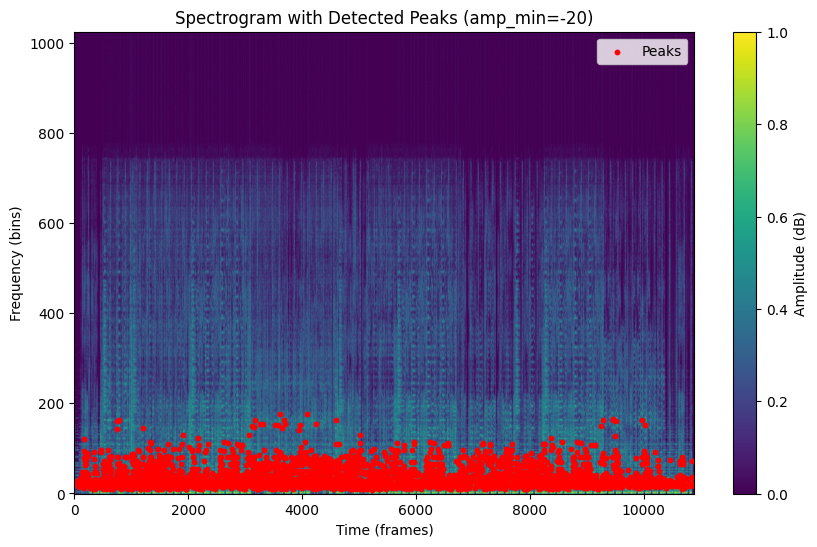

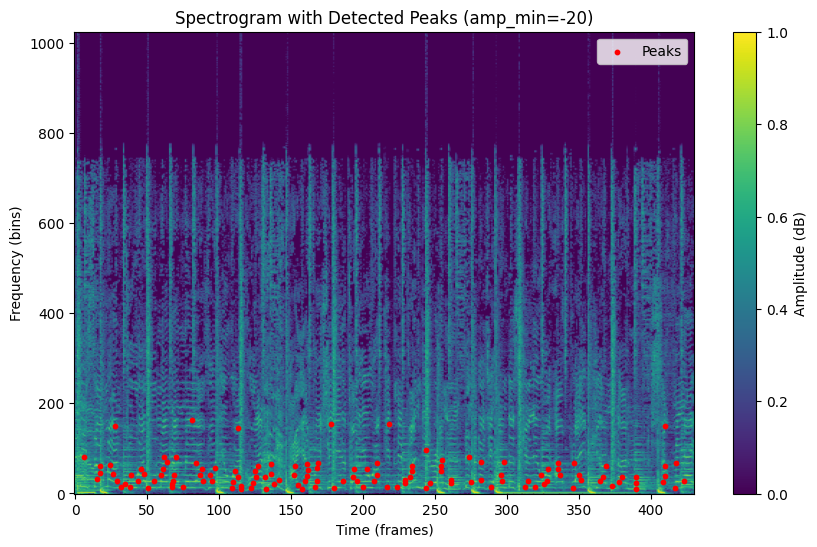

Generated 36043 fingerprints for the song.
Generated 1715 fingerprints for the clip.


In [4]:
song_fingerprints = simple_fingerprint(song_samples, song_sr, plot=True) # Added plot=True
# Simulate adding a song_id for the song fingerprints for compatibility with simple_match
song_fingerprints_with_id = [(1, h, o) for h, o in song_fingerprints]

clip_fingerprints = simple_fingerprint(clip_samples, clip_sr, plot=True) # Added plot=True

print(f"Generated {len(song_fingerprints_with_id)} fingerprints for the song.")
print(f"Generated {len(clip_fingerprints)} fingerprints for the clip.")

## Match clip

Match the clip fingerprints against the song fingerprints using the `simple_match` function.

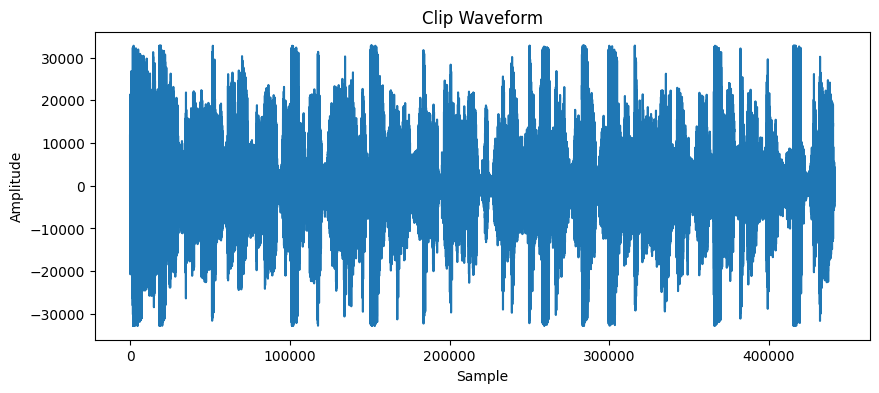

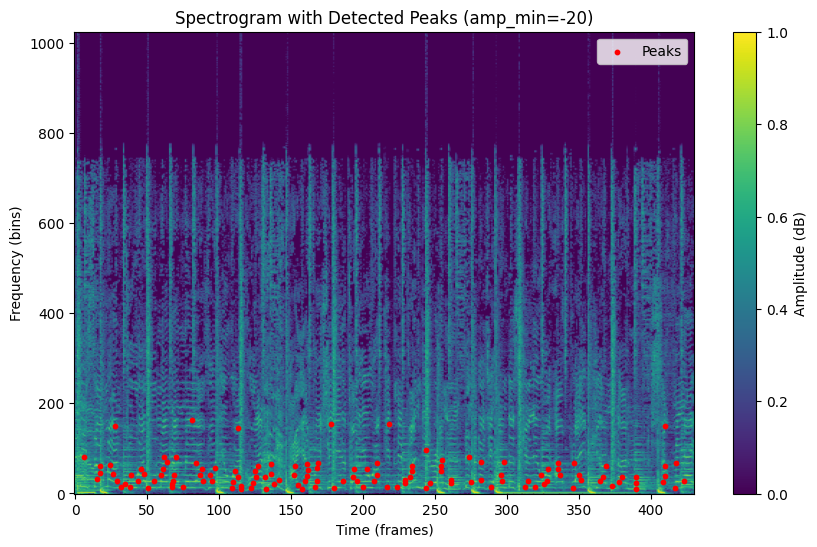

In [5]:
match_result = simple_match(clip_samples, clip_sr, song_fingerprints_with_id, plot=True) # Added clip_samples, clip_sr, and plot=True

## Display results

Print the matching results to show if a match was found and relevant details.

In [6]:
print(match_result)

{'match': True, 'song_id': 1, 'offset': 3087, 'hashes_matched': 802}


## Summary:

### Data Analysis Key Findings

* The song ("song1.wav") and clip ("clip1.wav") were loaded successfully.
* Fingerprints were generated for both the song and the clip using the simplified fingerprinting process.
* The simplified matching process found a match between the clip and the song.
* The match details indicate the song ID, the offset (time difference in frames), and the number of matched hashes. The number of matched hashes exceeded the simple match threshold, confirming the match.

### Insights or Next Steps

* This simplified demo successfully illustrates the core concept of audio fingerprinting and matching.
* The offset value can be used to pinpoint the exact location of the clip within the song.
* For a more robust system, you would integrate this logic with a database to store and query fingerprints for multiple songs and implement more sophisticated matching algorithms and confidence scoring.